# Time series sales prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [4]:
# Load data
df_raw = pd.read_csv('../data/raw/sales.csv')
df_raw.sample(10)

,date,sales
241,2023-05-02 17:10:08.079328,676.068459
111,2022-12-23 17:10:08.079328,341.622244
23,2022-09-26 17:10:08.079328,107.636519
236,2023-04-27 17:10:08.079328,668.730029
36,2022-10-09 17:10:08.079328,147.389502
321,2023-07-21 17:10:08.079328,883.040473
248,2023-05-09 17:10:08.079328,693.039359
243,2023-05-04 17:10:08.079328,681.572381
123,2023-01-04 17:10:08.079328,374.116144
216,2023-04-07 17:10:08.079328,612.140720


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [6]:
# Preprocessing
df_baking = df_raw.copy()

df_baking['date'] = pd.to_datetime(df_baking['date'], infer_datetime_format=True)
df_baking = df_baking.set_index('date')

df = df_baking.copy()

/tmp/ipykernel_16367/3903856546.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_baking['date'] = pd.to_datetime(df_baking['date'], infer_datetime_format=True)


In [40]:
# Save data
df.to_csv('../data/processed/sales_processed.csv')

In [7]:
df['sales'].describe().T

count     366.000000
mean      524.963968
std       275.089698
min        53.803211
25%       290.186822
50%       520.699468
75%       763.289263
max      1000.482785
Name: sales, dtype: float64

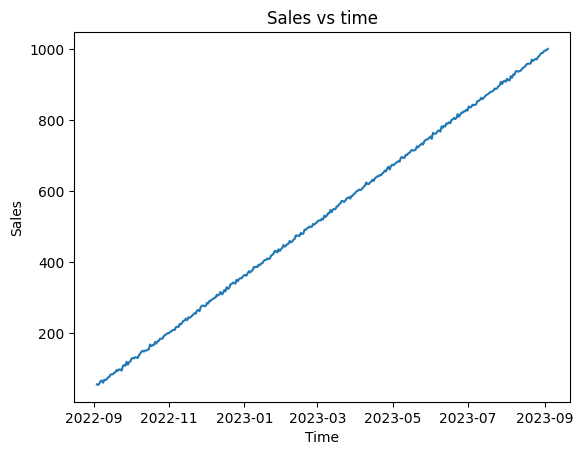

In [8]:
plt.plot(df)
plt.title('Sales vs time')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

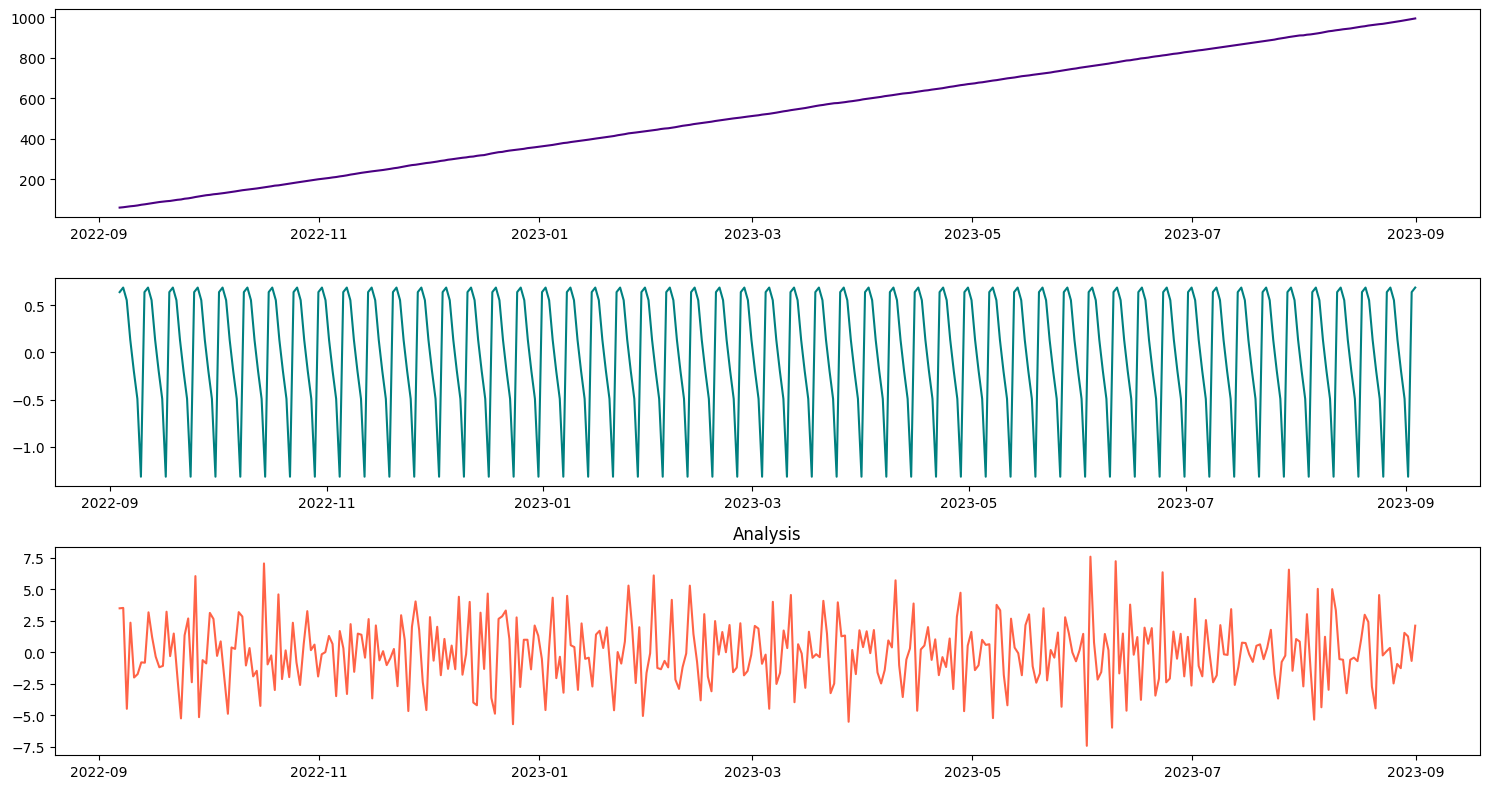

In [9]:
descomposition = seasonal_decompose(df)
trend = descomposition.trend
seasonal = descomposition.seasonal
residual = descomposition.resid

fig, ax= plt.subplots(3,1, figsize=(15, 8))

ax[0].plot(trend, c='indigo')
ax[1].plot(seasonal, c='teal')
ax[2].plot(residual, c='tomato')

plt.title('Analysis')
plt.tight_layout()
plt.show()

**Trend Analysis** -> The trend is continously upward without much (apparent) fluctuations. This can be due to the data being about cummulative sales. 

**Seasonality Analysis** -> The oscillations are consistent, there are repetitive cycles approximately each week

**Variability Analysis** -> The data fluctuates irregularly around 0, with random positive and negative spikes, but this seems as a moderate or controlled randomness since the mean stays consistent around 0. 

A Dickey-Fuller test will be conducted to determine if the time-series is stationary. 

In [10]:
# Dickey-Fuller test
test_dfuller = adfuller(df)

print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: 0.55
test p_value: 0.99


P-value is greater than the significance of 0.05, thus the alternative hypothesis is rejected, which means this series is non-stationary. The first derivative will be taken to see if the p-value drops so that the series can be stationary and then an ARIMA model can be used.  

In [11]:
df_1diff = df.diff(1).dropna()
test_dfuller= adfuller(df_1diff)

print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: -9.43
test p_value: 0.00


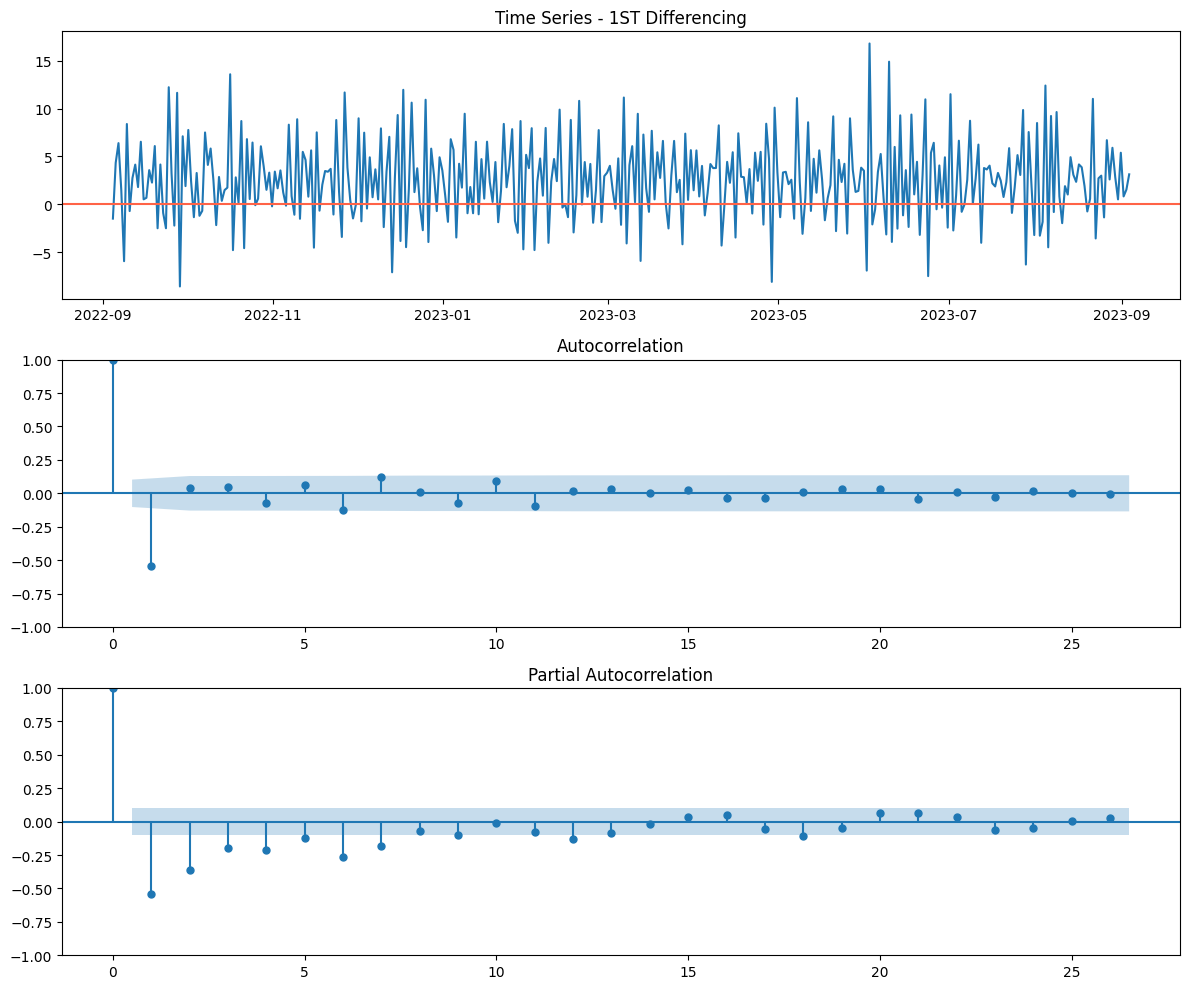

In [12]:
# Correlation
fig, ax = plt.subplots(3,1, figsize=(12, 10))

ax[0].plot(df_1diff)
ax[0].axhline(y=0, c='tomato')
ax[0].set_title('Time Series - 1ST Differencing')

plot_acf(df_1diff, ax=ax[1])
plot_pacf(df_1diff, ax=ax[2])

plt.tight_layout()
plt.show()

## Train ARIMA

In [24]:
model = auto_arima(df, seasonal=True, trace=True, m=7, suppress_warnings=True, d=None) # Weekly cycles as seen before

model.summary()

/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.12 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1970.972, Time=0.04 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1968.120, Time=0.29 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1968.220, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1966.919, Time=0.11 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1965.376, Time=0.71 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1965.211, Time=0.98 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1963.937, Time=0.80 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1967.822, Time=0.25 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=2094.918, Time=0.56 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1911.553, Time=0.67 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[7] intercept   : AIC=1917.197, Time=0.30 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1918.228, Time=0.44 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[7] intercept   : AIC=1913.417, Time=1.37 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=1918.474, Time=0.11 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=1912.522, Time=1.18 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[7] intercept   : AIC=1901.988, Time=0.92 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[7] intercept   : AIC=1905.777, Time=0.53 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[7] intercept   : AIC=1906.314, Time=0.97 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[7] intercept   : AIC=1904.742, Time=1.58 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=1905.975, Time=0.18 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[7] intercept   : AIC=1902.846, Time=1.41 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[7] intercept   : AIC=1891.008, Time=1.49 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[7] intercept   : AIC=1893.263, Time=0.53 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[7] intercept   : AIC=1893.569, Time=0.74 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[7] intercept   : AIC=1895.062, Time=2.30 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[7] intercept   : AIC=1892.655, Time=0.29 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[7] intercept   : AIC=1891.733, Time=2.18 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[7] intercept   : AIC=1887.110, Time=1.69 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,2)[7] intercept   : AIC=1889.655, Time=0.65 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[7] intercept   : AIC=1889.951, Time=1.19 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[7] intercept   : AIC=1891.501, Time=2.78 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,1)[7] intercept   : AIC=1888.651, Time=0.34 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,1)[7] intercept   : AIC=1888.023, Time=2.14 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[7] intercept   : AIC=1851.463, Time=2.32 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,2)[7] intercept   : AIC=1843.570, Time=1.94 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[7] intercept   : AIC=1844.459, Time=1.04 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[7] intercept   : AIC=1855.157, Time=1.51 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,2)[7] intercept   : AIC=1841.468, Time=1.98 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[7] intercept   : AIC=1840.566, Time=0.98 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[7] intercept   : AIC=1843.037, Time=0.71 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[7] intercept   : AIC=1852.961, Time=1.33 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,0)[7] intercept   : AIC=1840.827, Time=1.09 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[7] intercept   : AIC=1851.151, Time=2.06 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[7] intercept   : AIC=1838.085, Time=0.83 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[7] intercept   : AIC=1843.307, Time=0.48 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[7] intercept   : AIC=1848.795, Time=1.14 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[7] intercept   : AIC=1838.068, Time=1.98 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[7] intercept   : AIC=1838.101, Time=2.05 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=1838.043, Time=1.79 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=1836.951, Time=1.02 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=1841.532, Time=0.46 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=1845.891, Time=1.13 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.22 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=1837.331, Time=2.10 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.65 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=1.20 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=1.21 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=1.29 sec


/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7]             : AIC=inf, Time=0.93 sec

Best model:  ARIMA(2,1,1)(0,0,1)[7] intercept
Total fit time: 67.323 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  366
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 7)   Log Likelihood                -912.476
Date:                           Sun, 19 Oct 2025   AIC                           1836.951
Time:                                   23:01:06   BIC                           1860.351
Sample:                               09-03-2022   HQIC                          1846.251
                                    - 09-03-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5802      0.207     12.469      0.000       2.175       2.986
ar.L1         -0.0425      0.051     -0.834      0.404      -0.142       0.057
ar.L2          0.0500      0.056      0.894      0.372      -0.060       0.160
ma.L1         -0.9863      0.018    -54.696      0.000      -1.022      -0.951
ma.S.L7        0.1557      0.052      2.973      0.003       0.053       0.258
sigma2         8.4527      0.644     13.116      0.000       7.190       9.716
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.91   Prob(JB):                         0.81
Heteroskedasticity (H):               0.85   Skew:                             0.06
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/workspaces/sales-forecasting/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_16367/383207401.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sns.lineplot(df.last('30D'), c='b')


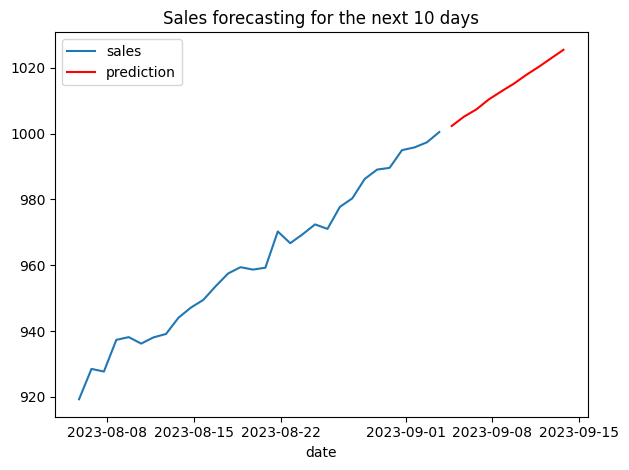

In [ ]:
forecast = model.predict(n_periods=10)

sns.lineplot(df.last('30D'), c='b')
sns.lineplot(forecast, c='r', label='prediction')

plt.title('Sales forecasting for the next 10 days'
plt.tight_layout()
plt.show()